In [149]:
import torch
from torch import nn
from kneed import KneeLocator

import math
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import torch.autograd as autograd

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import scipy.ndimage
from scipy.signal import savgol_filter

from sklearn.cluster import KMeans


torch.manual_seed(8)

In [232]:
""" Discriminator Class:
First Layer: size of features (the MS scan) + the number of clusters that the data set is labeled into. 
The default is that the data remains un clustered. This data is fit into different layers until the output is in the form of a 
number from 0-1, representing the realness or fakeness of the sample.

Note: in the future this, and the generator class can be experimented with for different datasets and such. The layer node counts can be 
slightly adjusted to fit the features of different datasets, assuming that they are relatively close in dimension 

"""

class Discriminator(nn.Module):
    def __init__(self, feature_size = 1050, clusters = 0):
        super().__init__() ## importing class from super
        self.model = nn.Sequential(
            nn.Linear(feature_size + clusters, 512), ## Note this is because there is 1050 inputs
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), #increased size for first layer
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2), #Uses ReLU activation
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            #nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1), #Last layer goes from 64 neurons to 1
            nn.Sigmoid(), ##using sigmoidal activation to create a single neuron output
        )
    def forward(self, x):
            output = self.model(x) #describes how the output of the model is calculated
            return output 

In [228]:
""" Generator Class:
First Layer: Noise Dimension (100) to generate random noise patterns from
Following Layers: Implements leakyReLU to drop out different inputs to prevent overfitting and overtraining. There are 4 Layers which go up
in size.
Output: The feature size (1050) + # of clusters. Consider using a parameter in order to fit to the desired output length
"""
class Generator(nn.Module): # Inherits from the nn.Module
    def __init__(self, noise_dim = 100, clusters = 0):
        super().__init__() ##allows you to create a nn architecture
        self.noise_dim = noise_dim 
        self.clusters = clusters
        
        
        self.model = nn.Sequential(
            
            nn.Linear(noise_dim, 256), ## taking noise vector of 100 to have more diversity
            #Learning Conditional Mapping: During training, the network learns how to use both the noise and the condition to produce realistic data 
            #that corresponds to the condition. The linear layer processes the combined input as a single entity, 
            #finding correlations between the noise and the condition that help it generate the desired output.

            
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), # Leaky ReLU prevents overfitting, especially since the sample sets have been relatively small
            nn.Linear(512, 1024), 
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1050 + self.clusters),  # Output layer producing 1050 features
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        return output



In [235]:
"""
MOMADatasetHandler:
    A Class that preprocesses the XINA 2021 testbed dataset.
    Constructor: 
        takes in the dataset file path, can either look at ‘sample’ or ‘category’ as a dataset
    Instance Methods:
        Provides methods to access and search through the dataset for desired samples
        Get_all_labels: Returns names of all unique labels
        Get_label_data: returns data for a specified label, i.e : ‘TiO2’
        Get_all_labels_data: get all data (including USIDs and Metadata). This is unprocessed data
    Static Methods:
        recommend_k_means(features): 
        divide_k_clusters(features, num_clusters): 
        label_features()

"""
class MOMADatasetHandler:
    #note this will only preprocess datasets that fit the same dimensions as the 2021 set
    def __init__(self, filepath, label_type):
        self.filepath = filepath
        self.label_type = label_type
        self.column_name = label_type + '_label'
        self.__training_data__ = pd.read_csv(filepath)
        self.__labels__ = None
        self.get_all_labels()


    def get_all_labels(self):
        column_name = f'{self.label_type}_label'
        self.__labels__ = self.__training_data__[column_name].unique().tolist()
        return self.__labels__
        

    def get_label_data(self, label):
        return self.__training_data__.loc[self.__training_data__[self.column_name] == label].copy()

        #features = training_data.loc[training_data[COLUMN] == CATEGORY_TYPE].copy()

    def get_all_labels_data(self):
        data_array = []
        for label in self.__labels__:
            data_array.append(self.__training_data__[label].copy())
            #print(self.__training_data__[label].head())

        return data_array

    def get_dataframe():
        return self.__training_data__

    def get_dataframe_diagnostic():
        return
        ## Unfinished Method
    
    """
        recommend_k_means(features): 
            Static method, where you can input a dataframe, 
            and it will use k_means clustering to recommend a certain “elbow” point. 
            In addition, the method will display a graph that showcases the clustered data as the elbow point increases.
    """
    def recommend_k_means(features):

        features = features.copy()
        
        features.drop(features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        features.drop(features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        features = features.drop(columns = ['USID'])
        WCSS=[]
        I = range(1, 20)
        
        for i in I:
          kmeans=KMeans(n_clusters=i,init='k-means++')
          kmeans.fit(features)
          WCSS.append(kmeans.inertia_)
        #print(WCSS)
        
        
        plt.plot(range(1,20),WCSS)
        
        kneedle = KneeLocator(I, WCSS, curve='convex', direction='decreasing')
        best_k = kneedle.elbow
        print(f"elbow at {best_k}")
    
    """
    divide_k_clusters(features, num_clusters): 
            Given a dataset, it will use k-means clustering to divide the data into that many clusters, 
            and return an array of clusters (with the data within the clusters).
    """
    def divide_k_clusters(features, num_clusters):
        features = features.copy()
        features.drop(features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        features.drop(features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        features = features.drop(columns = ['USID'])
        
        kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++')
        kmeans.fit(features)

        cluster_centers = kmeans.cluster_centers_
        labels = kmeans.labels_


        features['Cluster'] = labels

        # Split the data into separate clusters
        clusters = []
        for cluster in range(num_clusters):
            clusters.append(features[features['Cluster'] == cluster])
            print(f"Cluster {cluster} has {len(clusters[cluster])} scans")
            clusters[-1] = clusters[-1].drop(columns = ['Cluster'])
        
        return clustersset 

    """
    label_features(ans, num_clusters):
        Takes in a feature set, and clusters the data using k-means into num_clusters clusters. After that, labels are added to the new feature
        set representing each cluster. The new features with the additioinal labels are then returned.
    """
    
    def label_features(ans, num_clusters):
        features = ans.copy()
        features.drop(features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        features.drop(features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        features = features.drop(columns = ['USID'])
        
        kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++')
        kmeans.fit(features)

        cluster_centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        #print(real_set.size)
        # Split the data into separate clusters
        def overlap(key, array):
            ans = [0] * len(array)
            for index , curr in enumerate(array):
                if curr == key:
                    ans[index] = 1
            return ans
                    
        clusters = dict()
        for cluster in range(num_clusters):
            ans[str(cluster)] = 0
            to_add = overlap(cluster, labels) #(real_set[real_set['Cluster'] == cluster])
            ans[f"Cluster {cluster}"] = to_add

        #print(real_set.head())
        return ans

    """ 
    display_cluster_centers(feature, num_clusters):
        Given a feature set and a number of clusters, k-means is run to find the cluster centers. 
        These clusters are then showcased to show the user where these clustered datasets are centered around
    """
    def display_cluster_centers(feature, num_clusters):
        features = feature.copy()
        features.drop(features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        features.drop(features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        features = features.drop(columns = ['USID'])
        
        kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++')
        kmeans.fit(features)

        cluster_centers = kmeans.cluster_centers_

        for cluster in cluster_centers:
            plt.figure(figsize=(12, 6))
            plt.plot(cluster)
            plt.title('Mass Spectrometry Data - 50th Entry')
            plt.xlabel('m/z (mass/charge ratio)')
            plt.ylabel('Intensity')
            plt.xticks(ticks=range(0, len(cluster), 200))  # Show every 50th label
    
            plt.show()
        print(feature.head())
        


In [240]:
class GANDataHandler:
    
    
    def __init__(self, generator_path = None, discriminator_path = None, features = None, batch_size = 128, lr = .001, clusters = 0):
        
        
        def load_models(generator_path, discriminator_path):
            # Initialize the models
            generator = Generator()
            discriminator = Discriminator()
    
            # Load the state dictionaries
            generator.load_state_dict(torch.load(generator_path))
            discriminator.load_state_dict(torch.load(discriminator_path))

            return generator, discriminator
       

        
        if generator_path is not None and discriminator_path is not None and features is not None:
            self.generator, self.discriminator = load_models(generator_path, discriminator_path)
            self.features = features
        elif features is not None and generator_path is None and discriminator_path is None:
            self.features = features # MS Data
            self.generator = None
            self.discriminator = None

        
        self.scaler = MinMaxScaler() # Scaler. Used to fit transform data for the GANS and inverse transform to transform it back to GANS "size"
        self.batch_size = batch_size # # of samples being input at a time
        self.lr = lr # Learning Rate of the GANS

        ## Preprocessing Variables ##
        # Real Data used for training #
        self.real_data = None 
        self.real_labels = None
        self.real_set = None
        self.real_data_loader = None  # Dataloader to be used in training
        self.USIDs = None # USIDS will be merged later
        self.metadata = None
        
        ## Training Metrics to be Displayed by Classification Report ##
        # Average Loss over all training 
        self.avg_loss_g = None
        self.avg_loss_d = None
        # Number of Epochs trained on
        self.num_epochs_trained = 0
        # Average Accuracy of the Discriminator
        self.avg_disc_acc = None
        self.avg_gen_acc = None

        #cluster
        self.clusters = clusters


    
        

  
    """
        data_load():
            Load the data into the dataloader with labels.
    """
    def data_load(self, features):
        ## Preprocess data to be trained
        num_rows_to_drop = features.shape[0] % self.batch_size
        # Get the index of the rows to drop
        rows_to_drop = features.tail(num_rows_to_drop).index
        # Drop the rows
        features = features.drop(rows_to_drop)
        
        self.real_data = self.scaler.fit_transform(features)
        real_data_length = len(self.real_data)
        self.real_labels = torch.zeros(real_data_length)

        real_set = [ ## Zipping together labels and data to be used later
            (self.real_data[i], self.real_labels[i]) for i in range(real_data_length)
        ]
        
        self.real_data_loader = torch.utils.data.DataLoader(
            real_set, batch_size = self.batch_size, shuffle = True
        ) 

    """ 
        Augment Spectrum:
            A method to augment existing feature sets passed through to generate more testing data for xina. Things such as noise level transformation,
            peak shifting, scaling, and peak dropping are implemented to generate more data. These variables can be shifted with the passed in parameters

            Note: Not finished
            Note: Issues with memory + double pointing and aliasing.
            Note: Private method, only to be called by the preprocess constructor.

    """
    
    def augment_spectrum(self, noise_level=0.01, shift_level=0.01, scale_factor_range=(0.9, 1.1), drop_probability=0.05):
        ms_data_aug = self.features.copy()
        print(ms_data_aug.head())
        # Apply noise
        ms_data_aug += noise_level * np.random.normal(size=self.features.shape)
    
        # Apply peak shift
        #ms_data_aug[:, 0] += shift_level * np.random.normal(size=self.features[:, 0].shape)
    
        # Apply intensity scaling
        scale_factor = np.random.uniform(*scale_factor_range)
        ms_data_aug[:, 1] *= scale_factor
    
        # Random peak dropping
        drop_mask = np.random.rand(self.features.shape[0]) < drop_probability
        ms_data_aug[drop_mask, 1] = 0
    
        return ms_data_aug

        
    """ preprocess_data()
        Preprocesses the features data by scaling and creates a DataLoader for use in model training or evaluation. Saves USIDS and Meta Data to be merged later.
    
        Steps:
        1. Scale the feature data using the scaler's fit_transform method.
        2. Generate labels for the real data.
        3. Create a dataset by zipping together the scaled data and the corresponding labels.
        4. Initialize a DataLoader with the created dataset, setting the batch size and shuffling the data.
        
        This method is used after GANS is created;
    
        test = GANDataHandler(ms_data)
        test.preprocess_data
    
    """   
        
    def preprocess_data(self, augment = False):
        
        self.metadata = self.features.loc[:,'Laser_Energy':'formationprocess_label']
        self.features.drop(self.features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        self.features.drop(self.features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        self.USIDs = self.features['USID'].copy()
        self.features = self.features.drop(columns = ['USID'])

        if augment:
            new_data = self.augment_spectrum()
            self.features = pd.concat(self.features, new_data)

        self.data_load(self.features)
        print(self.features)


        
    
        
    """ display_features()
    Displays a graph of the feature data for a specified entry.

    This method plots the mass spectrometry data for a given entry, showing the intensity against the m/z (mass/charge ratio).

    Use:
    print(test.head()) #to find ids to input
    test.display_features(test_id)
    
    """
    def display_features(self, id):
        #entry = self.features[] ##Graphing of what our data should look like!
        print(self.features.head())
        entry = self.features.loc[id]
        plt.figure(figsize=(12, 6))
        plt.plot(entry)
        plt.title('Mass Spectrometry Data - 50th Entry')
        plt.xlabel('m/z (mass/charge ratio)')
        plt.ylabel('Intensity')
        plt.xticks(ticks=range(0, len(entry), 200))  # Show every 50th label

        plt.show()
    
    """ setup_optimizers()
    Sets up the loss function and optimizers for the discriminator and generator models.

    This method initializes the binary cross-entropy loss function and the Adam optimizers for both the discriminator and generator. 
    The learning rate for the generator's optimizer is set to be twice that of the discriminator's.

    Note: This is done within the train_model method, so this will not be needed to be called by the user
    """
    def setup_optimizers(self, discriminator, generator):
        loss_function = nn.BCELoss()
        optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = self.lr) ## Adam is the name of the optimizer we will use for the discriminator and generator
        optimizer_g = torch.optim.Adam(generator.parameters(), lr = self.lr * 2)

        return loss_function, optimizer_d, optimizer_g

    
    """ train_model()
    Trains the discriminator and generator models over a specified number of epochs.

    This method initializes the discriminator and generator models, sets up the optimizers and loss function,
    and trains the model.

    This method also keeps track of batch accuracy and other metrics to be displayed later
    
    Note: This method will be called by the user after creating the GANS and preprocessing the data
    """
    def train_model(self, num_epochs):
        discriminator = Discriminator(clusters = self.clusters)
        generator = Generator(clusters = self.clusters)
        loss_function, optimizer_d, optimizer_g = self.setup_optimizers(discriminator, generator)

        #Reset Batch Loss
        self.avg_loss_g, self.avg_loss_d = None, None
        self.avg_disc_acc, self.avg_gen_acc = None, None
        # Number of Epochs trained on
        self.num_epochs_trained = 0

        for epoch in range(num_epochs):

            NOISE_DIM = 100

            total_loss_d = 0
            total_loss_g = 0

            total_correct_d = 0
            total_samples_d = 0
            
            for n, (real_samples, _) in enumerate(self.real_data_loader):
                
                fake_labels = torch.zeros((self.batch_size, 1))
                real_labels = torch.ones((self.batch_size, 1))
                
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
                generated_samples = generator(latent_space_samples)
        
                all_samples = torch.cat((real_samples.to(torch.float32) , generated_samples.to(torch.float32)))
                all_sample_labels = torch.cat(
                    (real_labels, fake_labels)
                )
                all_sample_labels = all_sample_labels
                
                
                #Train the discriminator
                discriminator.zero_grad() # clear gradients at each step to avoid accumulation
                output_discriminator = discriminator(all_samples) #calculate output of the batch
                #print(output_discriminator.shape, all_sample_labels.shape)
                loss_discriminator = loss_function(
                    input = output_discriminator.view(-1), target = all_sample_labels.view(-1) ##loss function
                )
                loss_discriminator.backward() #calculate gradients to update weights (gradient descent)
                optimizer_d.step() #optimizer_discriminator.step()

                #calculate optimizer accuracy
                predicted_labels = (output_discriminator > 0.5).float()
                total_correct_d += (predicted_labels == all_sample_labels).sum().item()
                total_samples_d += all_sample_labels.size(0)
                
                #Time to train the generator
                
                #data for generator
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
        
                #Training the generator
                generator.zero_grad()
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = loss_function(
                    output_discriminator_generated, real_labels
                )
                loss_generator.backward()
                optimizer_g.step()

                total_loss_d += loss_discriminator
                total_loss_g += loss_generator
                

                 # Show loss
                if epoch % 10 == 0 and n == 5:
                    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

            #save generator and discriminator
            self.generator = generator
            self.discriminator = discriminator
            
            #Update Loss with updated batch loss
            batch_len = len(self.real_data_loader)
            batch_loss_g = total_loss_g / batch_len
            batch_loss_d = total_loss_d / batch_len

            #Update Avg Discriminator and Generator Accuracy for the current batch:
            avg_disc_acc = total_correct_d / total_samples_d
            
            fake_labels_for_gen_acc = torch.ones((self.batch_size, 1))
            output_discriminator_generated = discriminator(generated_samples)
            gen_pred_labels = (output_discriminator_generated > 0.5).float()
            gen_acc = (gen_pred_labels == fake_labels_for_gen_acc).sum().item() / self.batch_size

            self.num_epochs_trained += 1
            
            if not self.avg_loss_g and not self.avg_loss_d:
                self.avg_loss_g = batch_loss_g
                self.avg_loss_d = batch_loss_d
                self.avg_disc_acc = avg_disc_acc
                self.avg_gen_acc = gen_acc
                
            else:
                self.avg_loss_g = (batch_loss_g + (self.avg_loss_g * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_loss_d = (batch_loss_d + (self.avg_loss_d * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_disc_acc = (avg_disc_acc + (self.avg_disc_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_gen_acc = (gen_acc + (self.avg_gen_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained


    """ generate_samples()
    Generates synthetic samples using the trained generator model and saves them to a CSV file.

    This method generates samples from the latent space, transforms them back to the original scale,
    applies a moving average smoothing, and saves the results to a CSV file along with metadata.
    """
    def generate_samples(self, num_samples, num_batches = 1, smooth_filter = 'no_smooth'):
        filter_types = {'gauss', 'rolling', 'savitsky', 'no_smooth'}

        def moving_average(df, window_size):
            return df.rolling(window=window_size).mean()

        def gauss(df):
            return pd.DataFrame(scipy.ndimage.gaussian_filter(df.values, sigma=1), columns = df.columns) 

        def savitsky(df):
            POLYORDER = 3
            WINDOW_LENGTH = 10

            data_np = df.values
            smoothed_data_np = savgol_filter(data_np, window_length=WINDOW_LENGTH, polyorder=POLYORDER, axis=0)
            smoothed_df = pd.DataFrame(smoothed_data_np, columns=df.columns)
            return smoothed_df

        noise_dim = 100
        for batch in range(num_batches):
            latent_space_samples = torch.randn(num_samples, noise_dim) #100 is number of samples to make
            generated_samples = self.generator(latent_space_samples)
            generated_samples = generated_samples.detach()
            generated_samples = self.scaler.inverse_transform(generated_samples)
            graphed = generated_samples.clip(min = 0)
            
            
    
            # Example usage
            DF = pd.DataFrame(graphed)
            if smooth_filter in filter_types:
                if smooth_filter == 'rolling':
                    DF = moving_average(DF, window_size=5)
                elif smooth_filter == 'gauss':
                    DF = gauss(DF)
                elif smooth_filter == 'savitsky':
                    DF = savitsky(DF)
            else:
                smooth_filter = 'no_smooth'
    
        
            DF.insert(0, 'USID', self.USIDs)
            DF['USID'] = 'G' + DF['USID'].astype(str)
                
            for col in self.metadata.columns:
                DF[col] = self.metadata[col]
        
            ## Note this will be updated in later iterations
            CATEGORY_TYPE = 'CsI'
    
            if not os.path.exists('./generated_samples'):
                os.makedirs('./generated_samples')

            if num_batches == 1:
                DF.to_csv(f"./generated_samples/{CATEGORY_TYPE}_samples_{smooth_filter}.csv")
            else:
                DF.to_csv(f"./generated_samples/{CATEGORY_TYPE}_samples_{smooth_filter}_batch_{batch}.csv")
            
        # Select a few spectra to plot
        num_spectra_to_plot = 4
        spectra_indices = [0, 1, 2, 3, 4] # Change these indices to plot different spectra
        
        plt.figure(figsize=(12, 6))
        
        for i in spectra_indices:
            plt.plot(graphed[i], label=f'Spectrum {i+1}')
        
        plt.title("Mass Spectra")
        plt.xlabel("Mass/Charge (m/z)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()

    
    """ generate_classification_report()
    Generates and saves a classification report summarizing the training performance of the generator and discriminator models.

    This method prints the average generator and discriminator losses and accuracies, calculates the total number of samples trained,
    and saves these metrics to a CSV file.
    
    """
    def generate_classification_report(self, output_csv = 'classification_report.csv'):

        # Average Loss over all training 
        print(f"Average Generator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_g}")
        print(f"Average Discriminator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_d}")

        print(f"Average Generator Accuracy from the last train: {self.avg_gen_acc}")
        print(f"Average Discriminator Accuracy from the last train: {self.avg_disc_acc}")

        total_samples_trained = self.batch_size * self.num_epochs_trained

        with open(output_csv, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Metric', 'Value'])
                writer.writerow(['Average Generator Loss', self.avg_loss_g.item()])
                writer.writerow(['Average Discriminator Loss', self.avg_loss_d.item()])
                writer.writerow(['Average Generator Accuracy', self.avg_gen_acc])
                writer.writerow(['Average Discriminator Accuracy', self.avg_disc_acc])
                writer.writerow(['Total Samples Trained', total_samples_trained])
        
        print(f"Classification report saved to {output_csv}")
        # Average Accuracy of the Discriminator


    """ export_models()
    Exports the trained generator and discriminator models to the specified directory.

    This method saves the state dictionaries of the generator and discriminator models to the specified directory
    with filenames based on the given sample name.
    """
    def export_models(self, sample_name, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        generator_path = os.path.join(directory, f'{sample_name}_generator.pth')
        discriminator_path = os.path.join(directory, f'{sample_name}_discriminator.pth')
        
        torch.save(self.generator.state_dict(), generator_path)
        torch.save(self.discriminator.state_dict(), discriminator_path)
        
        print(f'Models saved in directory: {directory}')

    
    def display_feature_distribution(self):
        cpy = self.features.copy()
        cpy = cpy.loc['0':'1050'] 
        plt.figure(figsize=(12, 6))
        
        for row in self.features.index:
            plt.plot(self.features.loc[row])
        
        plt.title("Mass Spectra")
        plt.xlabel("Mass/Charge (m/z)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()

In [213]:
FILEPATH = './test_sample1.csv'

xina_data = MOMADatasetHandler(FILEPATH, 'sample')
xina_data.get_all_labels()

for label in xina_data.__labels__:
    curr = xina_data.get_label_data(label)
    print(label, curr.shape)
    

CsI (6789, 2013)
TiO2 (3045, 2013)
Forsterite (1228, 2013)
Phosphorus (392, 2013)
Rhodamine 6G (32, 2013)
Nontronite (9, 2013)
Gly+Ala+Ser mixture + CHCA (325, 2013)
Gypsum (2410, 2013)
Butterfinger (151, 2013)
Gabion Basalt (141, 2013)
Valine in Jerosite (100, 2013)
Yellowstone Green stream TLE (653, 2013)
Yellowstone Green stream powder (991, 2013)
Dolomite (313, 2013)
Mix in Mont (407, 2013)
Phe in Mont (824, 2013)
Phthalic Acid in Mont (556, 2013)
Atacama (850, 2013)
Ferrosilite (697, 2013)
Sanidine (1108, 2013)
Diopside (980, 2013)
Chlorophyll A (46, 2013)
Thin section (C coating) (529, 2013)
Graphite (113, 2013)
Magnetite (275, 2013)
Phospholipids (212, 2013)
MGDG (210, 2013)
DGDG (58, 2013)
Hopane (162, 2013)
Glu in Mont (102, 2013)
Saponite (45, 2013)
Montmorillonite (297, 2013)
Hematite (3754, 2013)
Mg Perc. in Mont (1, 2013)
Phthalic Acid in Mont + Mg Perc. (216, 2013)
AMP in Mont + Mg Perc. (1, 2013)
Glu in Mont + Mg Perc. (2, 2013)
Phe in Mont + Mg Perc. (359, 2013)
Mix in 

elbow at 6
             USID  0  1  2  3  4  5  6  7  8  ...   TIC  Max_Bin_Counts  \
12850  8373000001  0  0  0  0  0  0  0  0  0  ...  5941               8   
20391  8447000031  0  0  0  0  0  0  0  0  0  ...  3784               8   
20392  8447000032  0  0  0  0  0  0  0  0  0  ...  4553              13   
20393  8447000033  0  0  0  0  0  0  0  0  0  ...  5407              10   
20394  8447000034  0  0  0  0  0  0  0  0  0  ...  3503               8   

       Charge_Control  mcalDefault                         category_label  \
12850            0.01            1  Pure Mineral (Oxides/Oxide-hydroxide)   
20391            0.01            1  Pure Mineral (Oxides/Oxide-hydroxide)   
20392            0.01            1  Pure Mineral (Oxides/Oxide-hydroxide)   
20393            0.01            1  Pure Mineral (Oxides/Oxide-hydroxide)   
20394            0.01            1  Pure Mineral (Oxides/Oxide-hydroxide)   

       sample_label  formationprocess_label  Cluster 0  Cluster 1  Cluster 

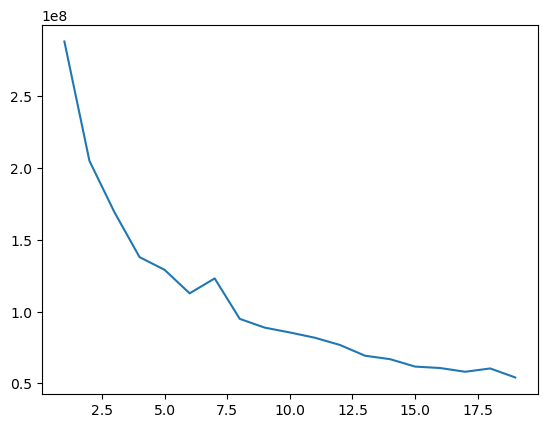

In [227]:
curr_sample = xina_data.get_label_data('Hematite')
MOMADatasetHandler.recommend_k_means(curr_sample)
Ti02 = MOMADatasetHandler.label_features(curr_sample, 3)
print(Ti02.head())

In [222]:
#print(curr_sample.head())
sample = GANDataHandler(features = Ti02, clusters = 3)
sample.preprocess_data()

       0  1  2  3  4  5  6  7  8  9  ...  1043  1044  1045  1046  1047  1048  \
12850  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
20391  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
20392  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
20393  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
20394  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...   .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
33344  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
33345  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
33346  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
33347  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
33348  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

       1049  Cluster 0  Cluster 1  Clus

Epoch: 0 Loss D.: 0.6961635947227478
Epoch: 0 Loss G.: 0.7289832830429077
Epoch: 10 Loss D.: 0.25908592343330383
Epoch: 10 Loss G.: 2.0747790336608887
Epoch: 20 Loss D.: 0.1504587084054947
Epoch: 20 Loss G.: 2.8648624420166016
Epoch: 30 Loss D.: 0.23807308077812195
Epoch: 30 Loss G.: 2.5143823623657227


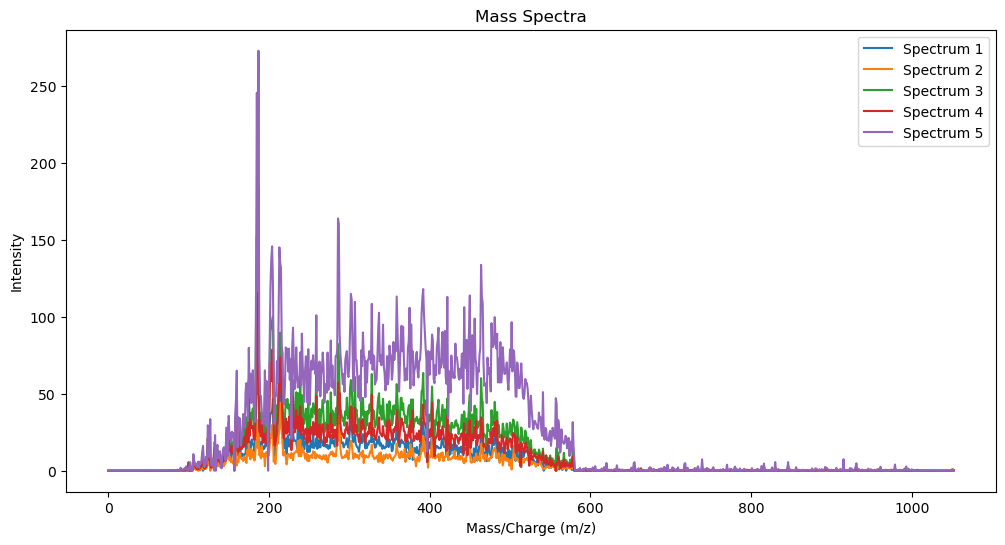

In [223]:
sample.train_model(num_epochs = 40)
sample.generate_samples(30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


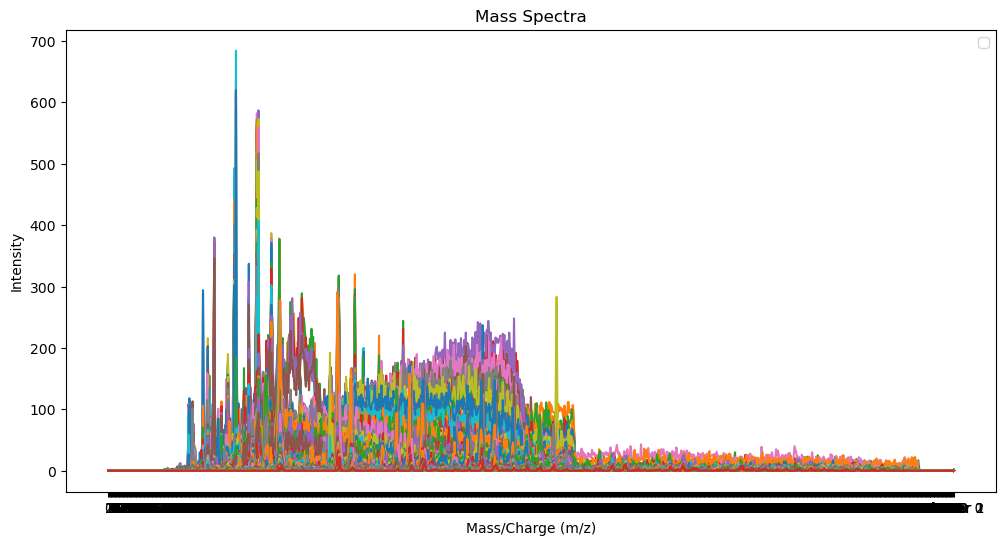

In [224]:
sample.display_feature_distribution()

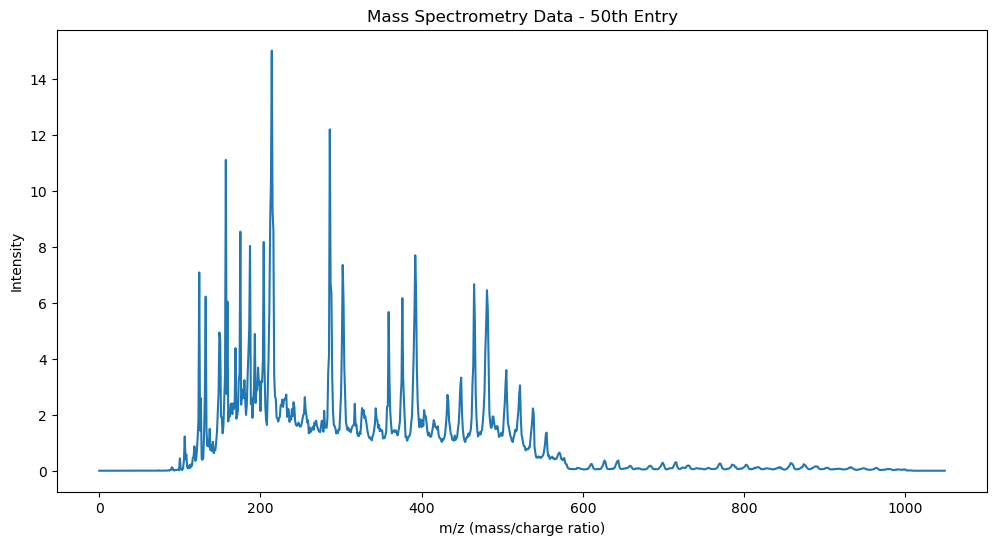

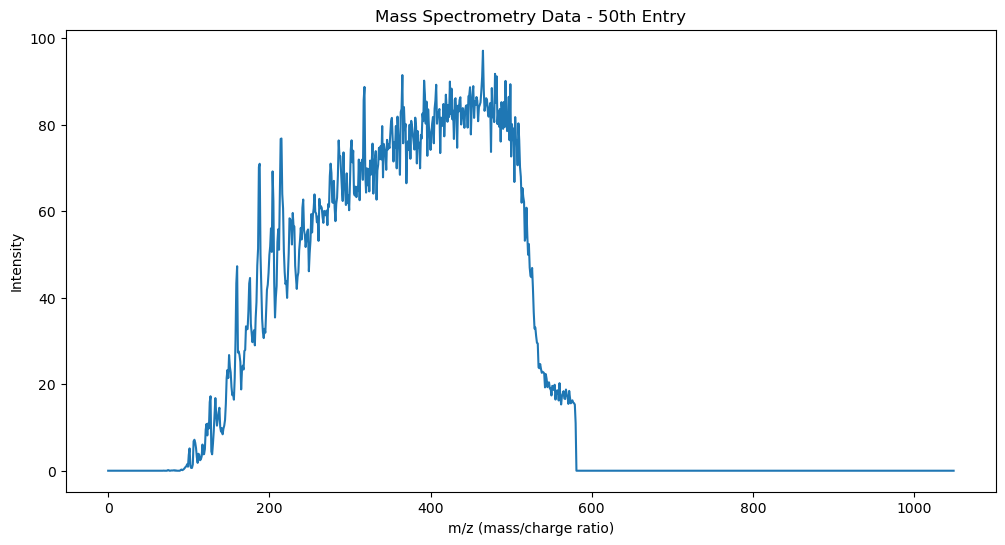

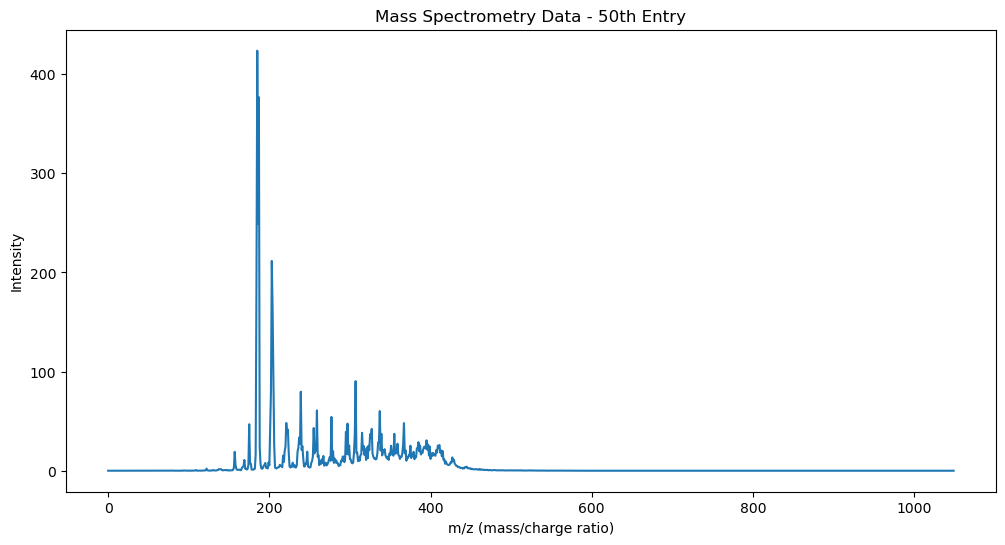

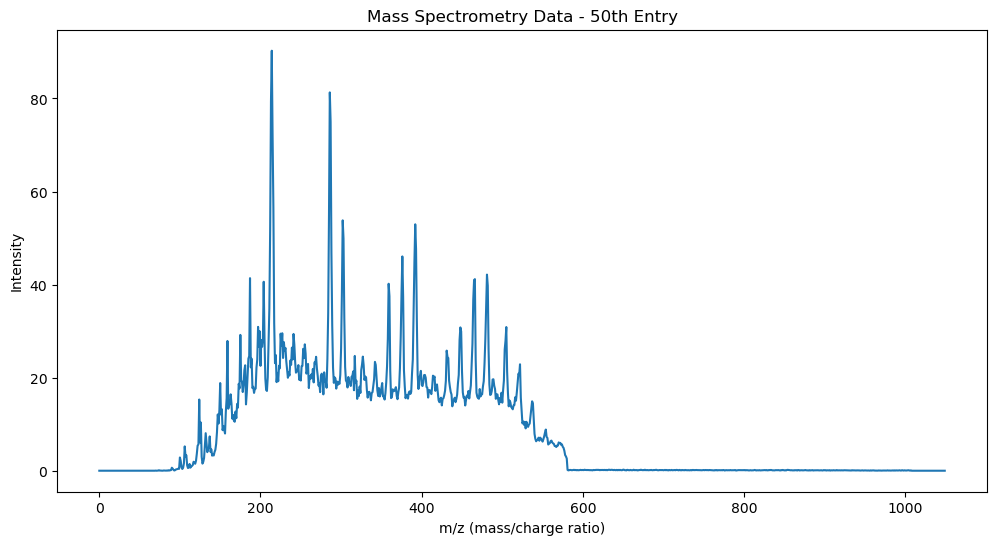

             USID  0  1  2  3  4  5  6  7  8  ...  Laser_Shots  Laser_StdDev  \
12850  8373000001  0  0  0  0  0  0  0  0  0  ...            2       0.31175   
20391  8447000031  0  0  0  0  0  0  0  0  0  ...            1       0.00000   
20392  8447000032  0  0  0  0  0  0  0  0  0  ...            1       0.00000   
20393  8447000033  0  0  0  0  0  0  0  0  0  ...            1       0.00000   
20394  8447000034  0  0  0  0  0  0  0  0  0  ...            1       0.00000   

       Phase   TIC  Max_Bin_Counts  Charge_Control  mcalDefault  \
12850      1  5941               8            0.01            1   
20391      1  3784               8            0.01            1   
20392      1  4553              13            0.01            1   
20393      1  5407              10            0.01            1   
20394      1  3503               8            0.01            1   

                              category_label  sample_label  \
12850  Pure Mineral (Oxides/Oxide-hydroxide)      Hema

In [226]:
MOMADatasetHandler.display_cluster_centers(xina_data.get_label_data('Hematite'), 4)

## Testing on Forsterite

elbow at 5


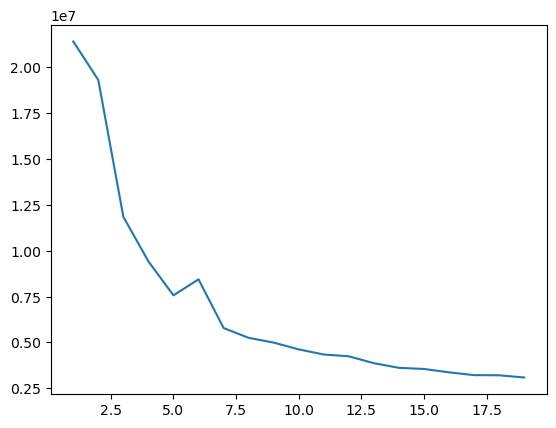

In [241]:
curr_sample = xina_data.get_label_data('Forsterite')
MOMADatasetHandler.recommend_k_means(curr_sample)


In [242]:
Ti02 = MOMADatasetHandler.label_features(curr_sample, 2)
print(Ti02.head())

           USID  0  1  2  3  4  5  6  7  8  ...  Phase  TIC  Max_Bin_Counts  \
825  8114000028  0  0  0  0  0  0  0  0  0  ...      2   34               5   
826  8114000033  0  0  0  0  0  0  0  0  0  ...      2   46               5   
827  8114000034  0  0  0  0  0  0  0  0  0  ...      2   36               4   
828  8114000041  0  0  0  0  0  0  0  0  0  ...      2   31               4   
829  8114000042  0  0  0  0  0  0  0  0  0  ...      2   31               3   

     Charge_Control  mcalDefault                  category_label  \
825            0.01            1  Pure Mineral (Clays/Silicates)   
826            0.01            1  Pure Mineral (Clays/Silicates)   
827            0.01            1  Pure Mineral (Clays/Silicates)   
828            0.01            1  Pure Mineral (Clays/Silicates)   
829            0.01            1  Pure Mineral (Clays/Silicates)   

     sample_label  formationprocess_label  Cluster 0  Cluster 1  
825    Forsterite                 Igneous         

In [243]:
sample = GANDataHandler(features = Ti02, clusters = 2)
sample.preprocess_data()

       0  1  2  3  4  5  6  7  8  9  ...  1042  1043  1044  1045  1046  1047  \
825    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
826    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
827    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
828    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
829    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...   .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
27580  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
27581  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
27582  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
27583  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
27584  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

       1048  1049  Cluster 0  Cluster 1

Epoch: 0 Loss D.: 0.6924375891685486
Epoch: 0 Loss G.: 0.7664539217948914
Epoch: 10 Loss D.: 0.4277665913105011
Epoch: 10 Loss G.: 2.048200845718384
Epoch: 20 Loss D.: 0.3226047456264496
Epoch: 20 Loss G.: 2.4645161628723145
Epoch: 30 Loss D.: 0.36655521392822266
Epoch: 30 Loss G.: 2.52606201171875
Epoch: 40 Loss D.: 0.14380677044391632
Epoch: 40 Loss G.: 3.6709747314453125
Epoch: 50 Loss D.: 0.26101285219192505
Epoch: 50 Loss G.: 2.080955982208252


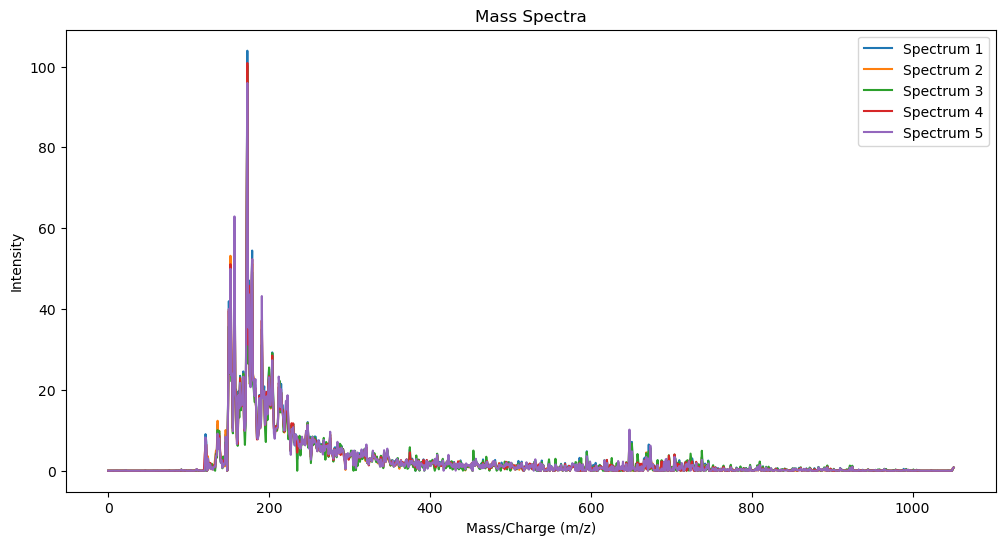

In [245]:
sample.train_model(num_epochs = 60)
sample.generate_samples(30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


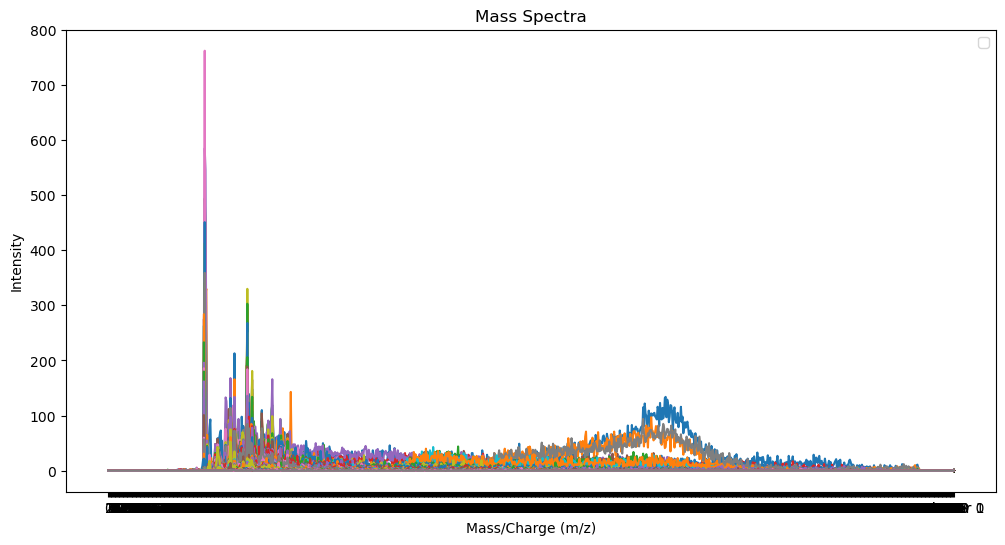

In [246]:
sample.display_feature_distribution()

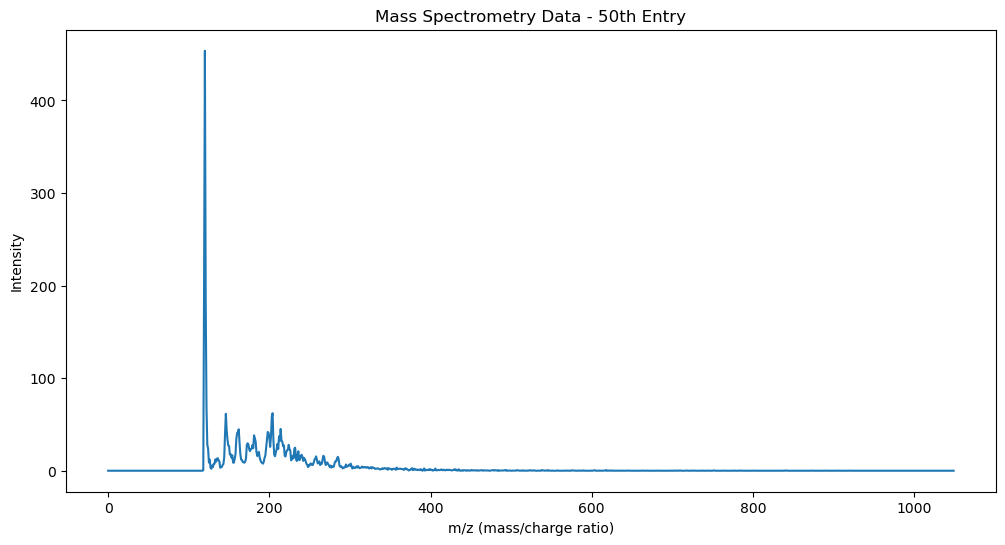

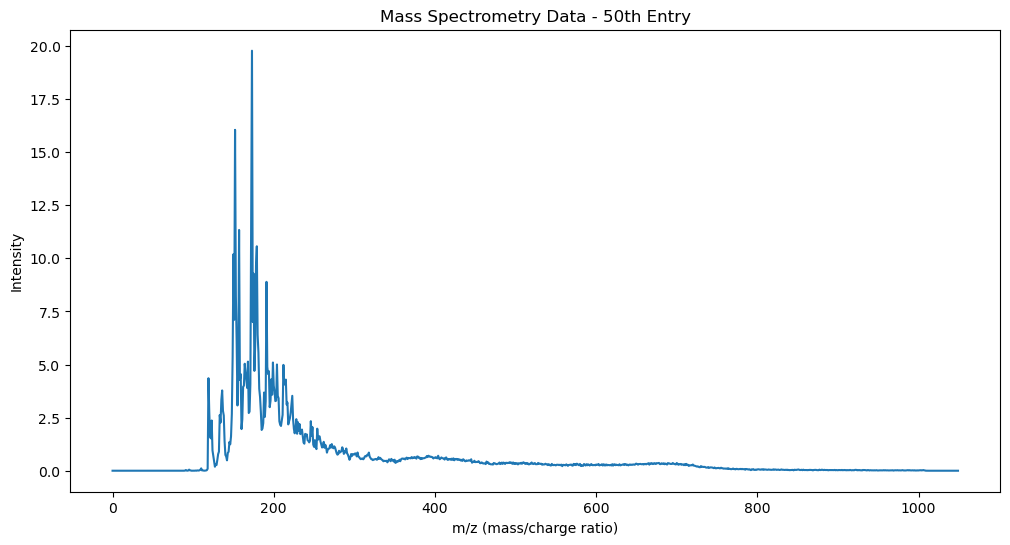

           USID  0  1  2  3  4  5  6  7  8  ...  Laser_Shots  Laser_StdDev  \
825  8114000028  0  0  0  0  0  0  0  0  0  ...            5      0.909793   
826  8114000033  0  0  0  0  0  0  0  0  0  ...            5      0.768654   
827  8114000034  0  0  0  0  0  0  0  0  0  ...            5      0.949998   
828  8114000041  0  0  0  0  0  0  0  0  0  ...            5      1.332690   
829  8114000042  0  0  0  0  0  0  0  0  0  ...            5      1.454650   

     Phase  TIC  Max_Bin_Counts  Charge_Control  mcalDefault  \
825      2   34               5            0.01            1   
826      2   46               5            0.01            1   
827      2   36               4            0.01            1   
828      2   31               4            0.01            1   
829      2   31               3            0.01            1   

                     category_label  sample_label  formationprocess_label  
825  Pure Mineral (Clays/Silicates)    Forsterite                 Igne

In [247]:
MOMADatasetHandler.display_cluster_centers(xina_data.get_label_data('Forsterite'), 2)